# Unsupervised Learning

The first step here, is to import our required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf


from sklearn.cluster import KMeans  
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, silhouette_score
from sklearn.preprocessing import StandardScaler  

from statsmodels.tsa.stattools import coint, adfuller
import statsmodels.api as sm 
sns.set_style("whitegrid")
np.random.seed(42) 

# Data acquisition and feature engineering 

The cell below performs data acquisition and feature engineering for a pairs trading machine learning project.

**1. Stock selection**

We define 41 stocks across 5 sectors. In our case the following sectors: Tech, Finance, Healthcare, Energy and Consumer, plus the SPY as the market benchmark.

**2. Data download**

Fetches 4 years of daily closing prices from 2020 to 2024 using yfinance. We then clean the missing data via forward-filling and dropping incomplete rows.

**3. Feature engineering (Basic Features)**

Currently calculated features for clustering stocks:

- **Annualized Mean Return**: `daily_return.mean() × 252` - measures profitability
- **Annualized Volatility**: `daily_return.std() × √252` - measures risk  
- **Market Beta**: `Cov(stock, market) / Var(market)` - measures systematic risk


In [2]:

tickers = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'AMD', 'INTC', 'CSCO', 'ORCL',  
    'JPM', 'BAC', 'WFC', 'C', 'GS', 'MS', 'AXP', 'V', 'MA',                          
    'XOM', 'CVX', 'COP', 'SLB', 'EOG', 'MPC', 'HAL',                                
    'JNJ', 'PFE', 'MRK', 'ABBV', 'TMO', 'UNH', 'LLY',                                
    'PG', 'KO', 'PEP', 'WMT', 'COST', 'MCD', 'SBUX',                                 
    'SPY'                                                                           
]

start_date = '2020-01-01' 
end_date = '2024-01-01'
print(f"Downloading data for {len(tickers)} tickers...")
data = yf.download(tickers, start=start_date, end=end_date)['Close']

data.dropna(axis=1, how='all', inplace=True)  
data.ffill(inplace=True)  
data.dropna(inplace=True)  

returns = data.pct_change().dropna()
market_returns = returns['SPY']  

features = pd.DataFrame(index=returns.columns)

features['mean_return'] = returns.mean() * 252  

features['volatility'] = returns.std() * np.sqrt(252) 
betas = []
for t in returns.columns:
    if t == 'SPY':
        betas.append(1.0)  
        continue
   
    cov = np.cov(returns[t], market_returns)[0, 1]  
    var = np.var(market_returns)
    betas.append(cov / var)

features['beta'] = betas

features = features.drop('SPY')
returns = returns.drop('SPY', axis=1)

print(data.head())
print("Feature Set Head:")
print(features.head())

C:\Users\cesar\AppData\Local\Temp\ipykernel_7120\3111192697.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  41 of 41 completed

Ticker           AAPL       ABBV        AMD       AMZN         AXP        BAC  \
Date                                                                            
2020-01-02  72.468269  69.823479  49.099998  94.900497  116.638573  30.920326   
2020-01-03  71.763733  69.160706  48.599998  93.748497  115.480064  30.278322   
2020-01-06  72.335556  69.706505  48.389999  95.143997  114.979607  30.234943   
2020-01-07  71.995354  69.308853  48.250000  95.343002  114.377174  30.035402   
2020-01-08  73.153496  69.800064  47.830002  94.598503  116.351273  30.339058   

Ticker              C        COP        COST       CSCO  ...          PG  \
Date                                                     ...               
2020-01-02  65.311005  52.563770  266.497498  40.688908  ...  106.273262   
2020-01-03  64.080826  52.756493  266.717041  40.025047  ...  105.558495   
2020-01-06  63.879795  53.382843  266.790009  40.167912  ...  105.704895   
2020-01-07  63.325039  53.382843  266.369537  39.907

# Unsupervised Learning: K-Means Clustering

**Goal:** Group stocks with similar risk-return characteristics to identify candidate pairs for trading.

**Why K-Means?**
- Pairs trading works best between stocks that behave similarly (same sector, similar volatility, similar market exposure)
- K-Means groups stocks by minimizing within-cluster variance using Euclidean distance
- This reduces our search space from 780 possible pairs (40 stocks) to only pairs within the same cluster (~30-50 pairs)

**Process:**

1. **Standardize Features** - Scale mean_return, volatility, and beta to equal importance (prevents volatility from dominating)

2. **Find Optimal K** - Use two diagnostic methods:
   - **Elbow Method**: Plot inertia vs K, look for the "elbow" where improvement slows
   - **Silhouette Score**: Measures cluster quality (0 to 1, higher = better separation)

3. **Fit Model** - Apply K-Means with optimal K to assign each stock to a cluster

4. **Visualize Results** - Pairplot shows how clusters separate in 3D feature space (return, volatility, beta)

**Mathematical Objective:**

K-Means minimizes the Within-Cluster Sum of Squares (WCSS):

$$J = \sum_{i=1}^{K} \sum_{x \in C_i} ||x - \mu_i||^2$$

where $\mu_i$ is the centroid (mean) of cluster $C_i$.

## Methodology overview
- Objective: cluster equities by risk/return traits to narrow peer sets for pairs trading.
- Data: 2020-2024 daily closes for 40 large-cap equities; SPY used as market benchmark for beta, then removed from clustering.
- Features: annualized mean return, annualized volatility, and market beta; computed from daily returns.
- Preprocessing: forward-fill gaps, drop residual missing rows, standardize features with `StandardScaler` to equalize scale.
- Algorithm: K-Means with multiple random initializations (`n_init=10`) across K in [2, 19].
- Model selection: inertia (elbow) and silhouette score to balance compactness and separation.
- Visualization: pairplot of standardized features colored by cluster to assess geometric separation.
- Reproducibility: fixed random seed (42); specify date range and tickers; remove SPY to avoid leakage of the benchmark into clusters.

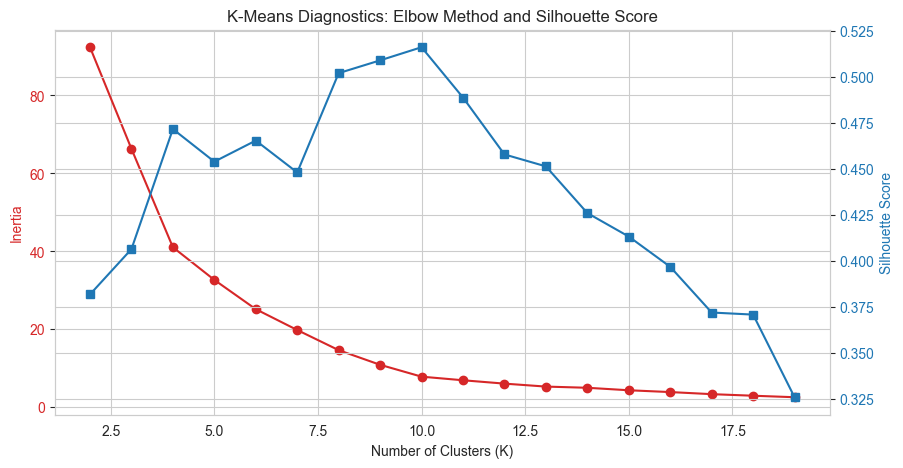

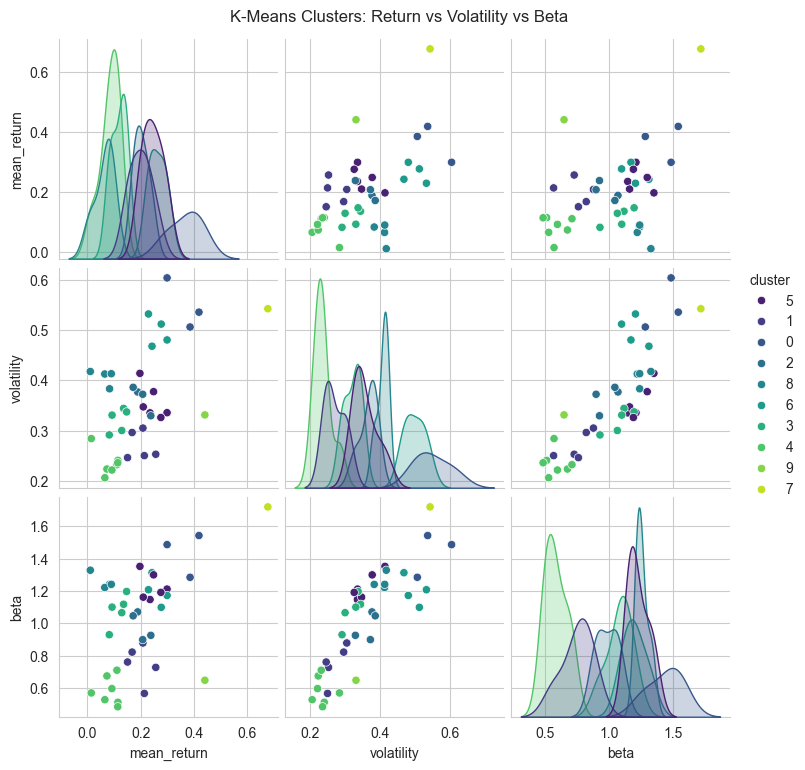


Cluster 0:
['AMD', 'HAL', 'MPC']

Cluster 1:
['ABBV', 'COST', 'MCD', 'TMO', 'UNH']

Cluster 2:
['AMZN', 'CVX', 'ORCL', 'XOM']

Cluster 3:
['CSCO', 'JPM', 'MA', 'SBUX', 'V']

Cluster 4:
['JNJ', 'KO', 'MRK', 'PEP', 'PFE', 'PG', 'WMT']

Cluster 5:
['AAPL', 'AXP', 'GOOGL', 'GS', 'MS', 'MSFT']

Cluster 6:
['COP', 'EOG', 'META', 'SLB']

Cluster 7:
['NVDA']

Cluster 8:
['BAC', 'C', 'INTC', 'WFC']

Cluster 9:
['LLY']


In [5]:

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

inertia = []
silhouette_scores = []
K_range = range(2, 20)  

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(features_scaled)
    inertia.append(km.inertia_)  
    silhouette_scores.append(silhouette_score(features_scaled, km.labels_))


fig, ax1 = plt.subplots(figsize=(10, 5))


color = 'tab:red'
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('Inertia', color=color)
ax1.plot(K_range, inertia, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(K_range, silhouette_scores, marker='s', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('K-Means Diagnostics: Elbow Method and Silhouette Score')
plt.show()


optimal_k = 10
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans.fit(features_scaled)

features['cluster'] = kmeans.labels_

features_plot = features.copy()
features_plot['cluster'] = features_plot['cluster'].astype(str)

sns.pairplot(features_plot, hue='cluster', palette='viridis', height=2.5)
plt.suptitle('K-Means Clusters: Return vs Volatility vs Beta', y=1.02)
plt.show()

for i in range(optimal_k):
    print(f"\nCluster {i}:")
    print(features[features['cluster'] == i].index.tolist())

## Results and interpretation
- Diagnostics: inertia decreases smoothly; silhouette peaks near K around 10 then tapers, supporting K=10 while acknowledging higher K risks overfitting small sample size (40 names).
- Geometry: pairplot shows clusters separate mainly along volatility and beta; mean return contributes less separation, indicating risk factors dominate.
- Practical use: focus pair selection within the same cluster to reduce search space; review cluster summaries (mean return, vol, beta) before trade design.
- Robustness checks: recompute on rolling windows to track cluster stability; monitor silhouette over time for regime shifts; test smaller K (3-6) for more interpretable, stable groups.
- Extensions: add downside metrics (max drawdown, downside deviation), factor exposures, liquidity, and valuation signals; try hierarchical clustering or Gaussian mixtures to capture non-spherical structure.